<a href="https://colab.research.google.com/github/setthavuth/deep-learning/blob/master/BKK_Condo_Pricing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏡 BKK Condo Pricing Analysis 

---

Buying a property is a significant financial and life decision. Condominium can be an attractive choice as it costs less than single-family home and can be easier to maintain. Buyers often look for the condo which has the best quality and provided facilities such as gym, pool, park and security. In this notebook, we will explore the condominium price around Bangkok and the factors effect the sale prices. **Let's get started!!!** 🔥


In [ ]:
import os
import json
import urllib
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup

## Collect Data with Web Scraping

---


In this section, we're going to collect condominium data around bangkok from [baania.com ](https://baania.com)

In [ ]:
# @title
url = 'https://www.baania.com/ขายคอนโด/กรุงเทพมหานคร?page=1'

response = requests.get(url)
print(response)

<Response [200]>


In [ ]:
# @title
soup = BeautifulSoup(response.text, 'html.parser')
#print(soup.prettify())
metadata = soup.find('script', type='application/json')
metadata = json.loads(metadata.string)

In [ ]:
# page reference:
# 'https://www.baania.com/ขายคอนโด/กรุงเทพมหานคร?page=1'

status_code = 200
condo_metadata = []
condo_on_sale = []

for num in tqdm(range(1, 53)):
  url = 'https://www.baania.com/ขายคอนโด/กรุงเทพมหานคร?page=' + str(num)

  response = requests.get(url)
  status_code = response.status_code
  #print(f'\tStart scraping page {num}')

  if status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    #print(soup.prettify())
    metadata = soup.find('script', type='application/json')
    metadata = json.loads(metadata.string)

    for condo in metadata['props']['pageProps']['defaultData']['hits']['hits']:
      #condo_metadata.append(condo['_source']['filter'])

      condo['_source']['view_data']['location'] = condo['_source']['location']
      condo['_source']['view_data']['address'] = condo['_source']['address']
      #condo_on_sale.append(condo['_source']['view_data'])
      for k, v in condo['_source']['view_data'].items():
        if k not in condo['_source']['filter']:
          condo['_source']['filter'][k] = v
        else:
          condo['_source']['filter'][k + '_1'] = v


      condo_metadata.append(condo['_source']['filter'])
  
#pd.DataFrame(condo_metadata).to_csv('condo_prices.csv', index = False, encoding = 'cp874')

100%|██████████| 52/52 [00:43<00:00,  1.21it/s]


In [ ]:
features = [
            'keyId', 'project_id', 'title', 
            'developerKeyId', 'developer',
            'address', 'location',
            'bedroom', 'bathroom', 'parking', 'bedroom_1', 'bathroom_1', 'parking_1',
            'area_usable', 'area_usable_1', 'floor', 'floor_1',
            'has_fitness', 'has_park', 'has_pool', 'has_security',
            'province', 'code', 'subdistrict', 'district',
            'score',
            'price', 'price_start',
            'sell_state', 'sell_state_1', 'sell_status'
            ]

# Data Preprocessing and Cleaning
condo_price = pd.DataFrame(condo_metadata)
condo_price = condo_price[features]
condo_price = condo_price[~condo_price['price_start'].isna()]
condo_price = condo_price[~condo_price['area_usable_1'].isna()]
condo_price = condo_price[condo_price['area_usable_1'] != '']

# Extract condo location
condo_price['lat'] = condo_price['location'].apply(lambda row: row['lat'])
condo_price['lon'] = condo_price['location'].apply(lambda row: row['lon'])

# Extract condo developer
condo_price['developer_th'] = condo_price['developer'].apply(lambda row: row['th'])
condo_price['developer_en'] = condo_price['developer'].apply(lambda row: row['en'])

# Extract condo project name
condo_price['title_th'] = condo_price['title'].apply(lambda row: row['th'])
condo_price['title_en'] = condo_price['title'].apply(lambda row: row['en'])

# Extract condo address
condo_price['province_title_th'] = condo_price['address'].apply(lambda row: row['province']['title']['th'])
condo_price['province_title_en'] = condo_price['address'].apply(lambda row: row['province']['title']['en'])

condo_price['district_title_th'] = condo_price['address'].apply(lambda row: row['district']['title']['th'])
condo_price['district_title_en'] = condo_price['address'].apply(lambda row: row['district']['title']['en'])

condo_price['subdistrict_title_th'] = condo_price['address'].apply(lambda row: row['subdistrict']['title']['th'])
condo_price['subdistrict_title_en'] = condo_price['address'].apply(lambda row: row['subdistrict']['title']['en'])

condo_price['postcode'] = condo_price['address'].apply(lambda row: row['postcode'])

condo_price = condo_price.reset_index()
condo_price.drop(['location', 'developer', 'address', 'title', 'index'], axis = 1, inplace = True)

#condo_price.head()

#condo_price['price_per_msq'] = condo_price.apply(lambda row: row['price_start'] / row['area_usable_1'], axis = 1)

#condo_price.to_csv('condo_price', index = False)
#condo_price.head()

In [ ]:
condo_price = condo_price.rename(columns = {
    'area_usable': 'area_usable_option',
    'bedroom': 'bedroom_option',
    'bathroom': 'bathroom_option',
    'parking': 'parking_option',
    'parking_1': 'parking',
    'area_usable_1': 'area_usable',
    'bedroom_1': 'bedroom',
    'bathroom_1': 'bathroom'
})

condo_price.head()

,keyId,project_id,developerKeyId,bedroom_option,bathroom_option,parking_option,bedroom,bathroom,parking,area_usable_option,...,developer_en,title_th,title_en,province_title_th,province_title_en,district_title_th,district_title_en,subdistrict_title_th,subdistrict_title_en,postcode
0,project_17051,17051,developer_10532,"[1, 2]","[1, 1]",[],1,1,"[None, None]","[29.12, 40.32]",...,บริษัท ห้าว หยาง พร็อพเพอร์ตี้ จำกัด,เอช วัน อ่อนนุช-ลาดกระบัง,H1 Onnut-Ladkrabang,กรุงเทพมหานคร,Bangkok,ลาดกระบัง,LAT KRABANG,ลาดกระบัง,LAT KRABANG,10520
1,5e7ae279944232001a5d4d70,5e7ae279944232001a5d4d70,developer_1745,"[1, 2]","[1, 1, 1]",[],1,1,"[None, None, None]","[23, 28, 43]",...,บริษัท แอล.พี.เอ็น.ดีเวลลอปเมนท์ จำกัด (มหาชน),ลุมพินี เพลส เตาปูน อินเตอร์เชนจ์,Lumpini Place Taopoon Interchange,กรุงเทพมหานคร,Bangkok,บางซื่อ,BANG SUE,บางซื่อ,BANG SUE,10800
2,project_17302,17302,developer_1758,"[1, 1, 1, 2]","[1, 1, 1, 1]",[],1,1,"[None, None, None, None]","[29.2, 25.61, 25.27, 29.43]",...,บริษัท ริชี่ เพลซ 2002 จำกัด (มหาชน),เดอะ ริช พระราม 9-ศรีนครินทร์,The Rich Rama 9-Sirnakarin,กรุงเทพมหานคร,Bangkok,สวนหลวง,SUAN LUANG,สวนหลวง,SUAN LUANG,10250
3,project_17095,17095,developer_1763,"[1, 1, 1]","[1, 1, 1]",[],1,1,"[None, None, None]","[28, 30, 35]",...,บริษัท เสนาดีเวลลอปเม้นท์ จำกัด (มหาชน),นิช ไอดี พระราม 2 - ดาวคะนอง เฟส 3,Niche ID Rama 2 - Dao Khanong Phase 3,กรุงเทพมหานคร,Bangkok,จอมทอง,CHOM THONG,บางมด,BANG MOT,10150
4,5e7b01aa944232001a5d4e50,5e7b01aa944232001a5d4e50,developer_2092,[1],[1],[],1,1,[None],[29],...,บริษัท วีไอพี กรุ๊ปส์ จำกัด,ไรย์ สุขุมวิท 101/1,Rye Sukhumvit 101/1,กรุงเทพมหานคร,Bangkok,พระโขนง,PHRA KHANONG,บางจาก,BANG CHAK,10260


## Feature Engineering

---


- **Price feature** represents the price per meter squared in thousand baht
- **Distance faeture** represent the distance to Thailand Public Train, such as BTS, MRT and Airport Rail Link.
- **Walkability distance**
- **Rideability distance**

**First, let's start with price feature**. 
<br> We first start with **price_start** as the original feature is not price per unit which is positively correlated with usable area, for example, started price should higher when you buy a larger usable area one. Please note that we represent price per msq in **thousand baht**.

In [ ]:
# Eliminate observation with zero usable area and zero started price 
condo_price = condo_price[(condo_price['area_usable'] > 0) & (condo_price['price_start'] > 0)]
condo_price['price_per_msq'] = condo_price.apply(lambda row: row['price_start'] / (row['area_usable'] * 1000), axis = 1)

Next let's walk through distance features. We can calculate distance between condo amd public train by using **Haversine Distances**.

In [ ]:
import math

def compute_distance(coord_1, coord_2):
  # Radius of earth in km
  R = 6373.0
  
  lat_1 = math.radians(coord_1[0])
  lon_1 = math.radians(coord_1[1])

  lat_2 = math.radians(coord_2[0])
  lon_2 = math.radians(coord_2[1])

  dlat = lat_2 - lat_1
  dlon = lon_2 - lon_1

  a = math.sin(dlat / 2) ** 2 + math.cos(lat_2) * math.cos(lat_1) * math.sin(dlon / 2) ** 2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

  distance = R * c

  return distance

Now, we will deal with distance features. The first two distance features are:

1. **Nearest public train (nearest_stationId)** represents nearest public train station mseasured in kilometer (km) around condo
2. **Nearest distance to public train (nearest_distance_to_station)** represents distance from condo to the nearest public train station in km.

In this section, we use additional dataset, [Thailand public train (Bangkok Area)](https://www.kaggle.com/datasets/gusbell/thailand-public-train-data-bangkok-area), published in kaggle

In [ ]:
# @title

import operator
from collections import defaultdict

STATION_PATH = '/content/drive/MyDrive/thailand_public_train'
stations = pd.read_csv(os.path.join(STATION_PATH, 'data.csv'))

min_distance_from_public_train = []

for _, condo in tqdm(condo_price.iterrows()):
  dist_dict = {}

  condo_coord = (condo['lat'], condo['lon'])

  for _, station in stations.iterrows():
    #print(condo['title_th'], '->', station['stationId'])
    station_coord = (station['geoLat'], station['geoLng'])
    dist_dict[station['stationId']] = compute_distance(condo_coord, station_coord)

  nearest_station = min(dist_dict.items(), key = operator.itemgetter(1))[0]

  #print(nearest_station, dist_dict[nearest_station])
  min_distance_from_public_train.append(
      {
          'nearest_stationId': nearest_station,
          'nearest_distance_to_station': dist_dict[nearest_station]
      }
  )

condo_price[['nearest_stationId', 'nearest_distance_to_station']] = pd.DataFrame(min_distance_from_public_train)

condo_price = condo_price.merge(
    stations[['stationId', 'name', 'lineName', 'lineNameEng', 'lineServiceName', 'geoLat', 'geoLng']],
    left_on = 'nearest_stationId', right_on = 'stationId'
)

2349it [00:19, 118.40it/s]


Besides of the nearest public train, we will find the nearest distance to different public train service to measure the convinience of transportation.

---



1. **Nearest BTS Station (nearest_bts_station)** represents the nearest BTS station around condo.
2. **Nearest Distance to BTS Station (nearest_bts_distance)** represent distance to nerest BTS station.
3. **Nearest MRT Station (nearest_mrt_station)** represents the nearest MRT station around condo
4. **Nearest Distance to MRT Station (nearest_mrt_distance)** represent distance to nearest MRT station
5. **Nearest Airport Rail Link Station (nearest_airportlink_station)** represents the nearest Airport Rail Link station around condo
6. **Nearest Distance to Airport Rail Link Station (nearest_airportlink_distance)** represent distance to nearest Airport Rail Link station

In [ ]:
# @title

service_name = ['BTS', 'MRT', 'AIRPORTLINK']

nearest_distance_from_service ={
    'BTS': [],
    'MRT': [],
    'AIRPORTLINK': []
}

for service in tqdm(service_name):
  for _, condo in condo_price.iterrows():
    dist_dict = defaultdict(float)
    condo_coord = (condo['lat'], condo['lon'])

    for _, station in stations[stations['lineServiceName'] == service].iterrows():
      station_coord = (station['geoLat'], station['geoLng'])
      dist = compute_distance(condo_coord, station_coord)
      dist_dict[station['stationId']] = dist
    
    nearest_station = min(dist_dict.items(), key = operator.itemgetter(1))[0]
    nearest_distnce = dist_dict[nearest_station]

    nearest_distance_from_service[service].append({
        'nearest_' + service.lower() + '_station': nearest_station,
        'nearest_' + service.lower() + '_distance': nearest_distnce
    })

100%|██████████| 3/3 [00:29<00:00,  9.78s/it]


In [ ]:
# @title

for service in service_name:

  station_col_name = 'nearest_'  + service.lower() + '_station'
  dist_col_name = 'nearest_'  + service.lower() + '_distance'

  condo_price[[station_col_name, dist_col_name]] = pd.DataFrame(nearest_distance_from_service[service])

Another two features I would like to add are:

---


**1. Walkability Distance**: As you may know, many project developer often adertise that their condominiums are nearby public transportation like BTS and MRT. However, the actual distances to public train are somtimes 3-5 km. In this case study, we assume that **walkabiity distance should not be more than 0.4 km**.
<br> **2. Rideability Distance**: If you have been to Thailand, you probably have to take a **Motorbike Taxi**. Because of the rush hours and horrible traffic condition, many bangkokians prefer to take motorbike taxi rather than driving. In this case study, we assume that **rideability distance should not more than 1.2 km**. 
<br> **3. Driving Distance**: Any other distances greater than 1.2 km will be labeled as Driving Distance.


> You may wonder how I came up with this walkability and rideability distance. Don't worry, I have researched on Pantip.com the most insightful and reliable community which provide you useful information 🤪



In [ ]:
# @title

def find_convinience(dist):
  if dist < 0.4:
    return 'Walking'
  elif dist < 1.2:
    return 'Riding'
  else:
    return 'Driving'

condo_price['trip_type'] = condo_price['nearest_distance_to_station'].apply(
    lambda dist: find_convinience(dist)
)

condo_price.head()

,keyId,project_id,developerKeyId,bedroom_option,bathroom_option,parking_option,bedroom,bathroom,parking,area_usable_option,...,lineServiceName,geoLat,geoLng,nearest_bts_station,nearest_bts_distance,nearest_mrt_station,nearest_mrt_distance,nearest_airportlink_station,nearest_airportlink_distance,trip_type
0,project_17051,17051,developer_10532,"[1, 2]","[1, 1]",[],1,1,"[None, None]","[29.12, 40.32]",...,AIRPORTLINK,13.732814,100.691318,E11,12.775531,BL19,17.228267,A2,3.641733,Driving
1,project_2530,2530,developer_1961,"[1, 1, 2]","[1, 1, 2]",[],1,1,"[None, None, None]","[33, 50, 92]",...,AIRPORTLINK,13.732814,100.691318,E11,8.552267,BL19,13.030555,A2,1.725661,Driving
2,project_17295,17295,developer_9533,[1],[1],[],1,1,[None],[32],...,AIRPORTLINK,13.732814,100.691318,E11,23.394117,BL18,27.735279,A1,8.037471,Driving
3,project_16914,16914,developer_1745,"[2, 1]","[1, 1, 1]",[],0,1,"[None, None, None]","[24, 44, 27]",...,AIRPORTLINK,13.732814,100.691318,E12,2.668512,BL23,8.972580,A3,7.309004,Driving
4,project_3124,3124,developer_1853,"[1, 2]","[1, 1]",[],1,1,"[None, None]","[25, 38]",...,AIRPORTLINK,13.732814,100.691318,N19,0.217184,BL14,9.748325,A4,16.183393,Driving


In [ ]:
condo_price.to_csv(
    os.path.join(
        '/content/drive/MyDrive/thailand_condo_price',
        'bkk_condo_price.csv'
    ), 
    index = False, encoding = 'utf-8'
)

## Exploratory Data Analysis


---





In [ ]:
# @title

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

plt.style.use('ggplot')

CONDO_PATH = '/content/drive/MyDrive/thailand_condo_price'
STATION_PATH = '/content/drive/MyDrive/thailand_public_train'

condo_price = pd.read_csv(os.path.join(CONDO_PATH, 'bkk_condo_price.csv'))
#condo_price = condo_price[(condo_price['area_usable_1'] > 0) & (condo_price['price_start'] > 0)]

stations = pd.read_csv(os.path.join(STATION_PATH, 'data.csv'))

condo_price.head()

,keyId,project_id,developerKeyId,bedroom_option,bathroom_option,parking_option,bedroom,bathroom,parking,area_usable_option,...,lineServiceName,geoLat,geoLng,nearest_bts_station,nearest_bts_distance,nearest_mrt_station,nearest_mrt_distance,nearest_airportlink_station,nearest_airportlink_distance,trip_type
0,project_17051,17051,developer_10532,"[1, 2]","[1, 1]",[],1,1,"[None, None]","[29.12, 40.32]",...,AIRPORTLINK,13.732814,100.691318,E11,12.775531,BL19,17.228267,A2,3.641733,Driving
1,project_2530,2530,developer_1961,"[1, 1, 2]","[1, 1, 2]",[],1,1,"[None, None, None]","[33, 50, 92]",...,AIRPORTLINK,13.732814,100.691318,E11,8.552267,BL19,13.030555,A2,1.725661,Driving
2,project_17295,17295,developer_9533,[1],[1],[],1,1,[None],[32],...,AIRPORTLINK,13.732814,100.691318,E11,23.394117,BL18,27.735279,A1,8.037471,Driving
3,project_16914,16914,developer_1745,"[2, 1]","[1, 1, 1]",[],0,1,"[None, None, None]","[24, 44, 27]",...,AIRPORTLINK,13.732814,100.691318,E12,2.668512,BL23,8.972580,A3,7.309004,Driving
4,project_3124,3124,developer_1853,"[1, 2]","[1, 1]",[],1,1,"[None, None]","[25, 38]",...,AIRPORTLINK,13.732814,100.691318,N19,0.217184,BL14,9.748325,A4,16.183393,Driving


### First, Analyzing Sale Price

Text(0.5, 1.0, 'Log(sale price)')

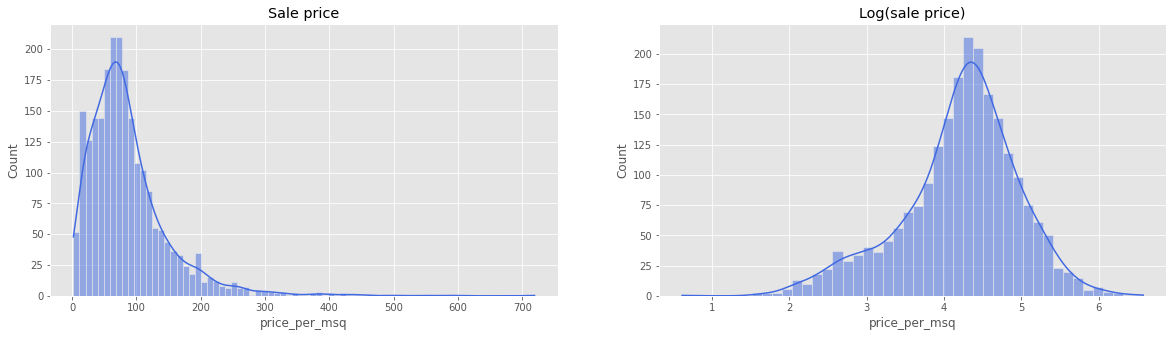

In [ ]:
# @title
# plt.figure(figsize = (10, 5))

fig, ax = plt.subplots(ncols = 2, figsize = (20, 5))

sns.histplot(condo_price['price_per_msq'], color = 'royalblue', kde = True, ax = ax[0])
sns.histplot(np.log(condo_price['price_per_msq']), color = 'royalblue', kde = True, ax = ax[1])

ax[0].set_title('Sale price')
ax[1].set_title('Log(sale price)')

All sale prices seem to be greater than zero and looks good. Most of the condo sale prices are between 45K to 107K THB.

In [ ]:
# @title
display(pd.DataFrame(condo_price['price_per_msq'].describe()).transpose())

print('\nSkewness: ', condo_price['price_per_msq'].skew())
print('Kurtosis: ', condo_price['price_per_msq'].kurt(), '\n')

,count,mean,std,min,25%,50%,75%,max
price_per_msq,2253.0,86.197399,64.184118,1.842105,45.714286,73.4375,107.916667,719.047619



Skewness:  2.414339788646874
Kurtosis:  11.282750648391369 



### What factor effects the Bangkok condo price?

### Condo Size and facility

Condominium facility is one of the factors that people consider whether they should buy the condominium or not. People often condider depends on the facilities like gym, co-working space and security of their living space. In this case study, we consider the data got from web scraping as below:
- **Security (has_security)** 
- **Pool (has_pool)**
- **Park (has_park)**

We will inspect and take a look whether these facilities effect sale price or not.

Text(0.5, 0.98, 'Condo Sale Price (Thousand THB) with facilities')

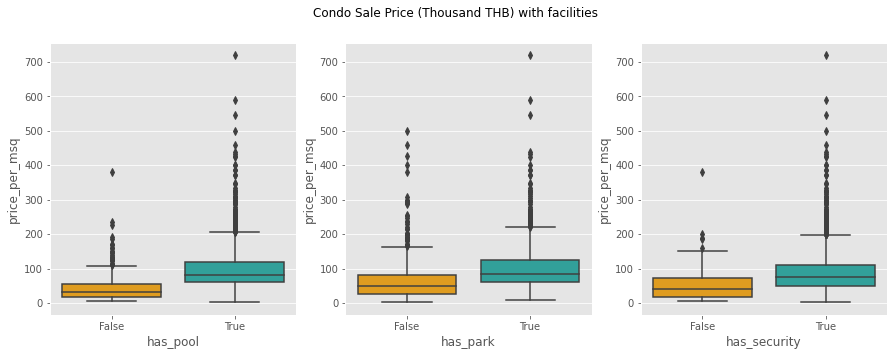

In [ ]:
# @title

fig, axes = plt.subplots(ncols = 3, figsize = (15, 5))

sns.boxplot(
    x ='has_pool',
    y = 'price_per_msq', 
    data = condo_price,
    #hue = 'has_pool',
    palette = {True: 'lightseagreen', False: 'orange'},
    ax = axes[0]
)

sns.boxplot(
    x ='has_park',
    y = 'price_per_msq', 
    data = condo_price,
    palette = {True: 'lightseagreen', False: 'orange'},
    ax = axes[1]
)

sns.boxplot(
    x ='has_security',
    y = 'price_per_msq', 
    data = condo_price,
    palette = {True: 'lightseagreen', False: 'orange'},
    ax = axes[2]
)

plt.suptitle('Condo Sale Price (Thousand THB) with facilities')

As we can see from the boxplot, sale price of the condominium which these facilities are available looks higher than those which doesn't. 
<br> We can keep these features to construct regression model later 😀

Next, we will take a look on condo size

,count,mean,std,min,25%,50%,75%,max
area_usable,2253.0,41.967399,40.748087,16.0,26.0,30.0,40.0,453.0


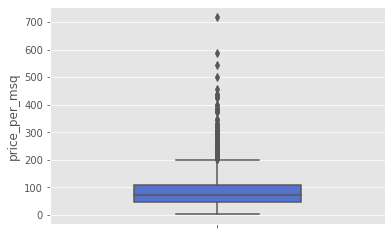

In [ ]:
# @title

display(pd.DataFrame(condo_price['area_usable'].describe()).transpose())
print('\n')

sns.boxplot(
    y = 'price_per_msq', 
    data = condo_price, 
    color = 'royalblue',
    width = 0.5
  )

Max usable area is 453.0 msq!!! This looks weird but it's possible. Let's take a look on outlier of area_usable variable.  

Normal Condo Area


,count,mean,std,min,25%,50%,75%,max
price_per_msq,2025.0,83.108685,58.823545,1.842105,43.727273,71.944444,106.785714,545.454545




Outlier Condo Area


,count,mean,std,min,25%,50%,75%,max
price_per_msq,224.0,113.072369,95.964221,12.025316,59.25,87.084475,125.544425,719.047619


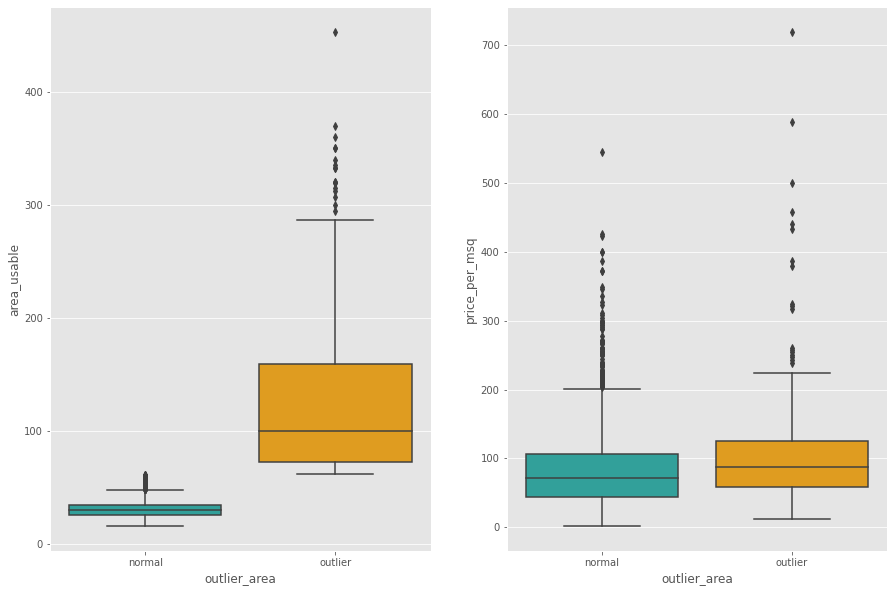

In [ ]:
# @title

outlier_baseline = 40 + 1.5 * (40 - 26)

print('Normal Condo Area')
display(pd.DataFrame(condo_price[condo_price['area_usable'] < outlier_baseline].loc[:, 'price_per_msq'].describe()).transpose())
print('\n')
print('Outlier Condo Area')
display(pd.DataFrame(condo_price[condo_price['area_usable'] > outlier_baseline].loc[:, 'price_per_msq'].describe()).transpose())
print('\n')


condo_price['outlier_area'] = condo_price['area_usable'].apply(lambda area: 'outlier' if area > outlier_baseline else 'normal')

fig, axes = plt.subplots(ncols = 2, figsize = (15, 10))

sns.boxplot(
    x = 'outlier_area',
    y = 'area_usable',
    data = condo_price,
    palette = {'normal': 'lightseagreen', 'outlier': 'orange'},
    ax = axes[0]
)

sns.boxplot(
    x = 'outlier_area',
    y = 'price_per_msq',
    data = condo_price,
    palette = {'normal': 'lightseagreen', 'outlier': 'orange'},
    ax = axes[1]
)

The outliers are sigficantly different from the normal one and sale prices look higher. I observed that the condominiums with large usable area are **luxury condo** and **super penthouse** so we can conclude that those are **high-end condominium**. 

In [ ]:
condo_title = ['keyId', 'title_en', 'developer_en', 'district_title_en', 'area_usable', 'price_per_msq']
condo_price[condo_price['area_usable'] > outlier_baseline].loc[:, condo_title]

,keyId,title_en,developer_en,district_title_en,area_usable,price_per_msq
13,5f3fa25a6320a60019751388,Sindhorn Tonson,บริษัท สยามสินธร จำกัด,PATHUM WAN,85.0,223.529412
14,project_8079,The Residences At Mandarin Oriental,บริษัท ดิ ไอคอนสยาม ซูเปอร์ลักซ์ เรสซิเดนซ์ คอ...,KHLONG SAN,128.0,433.593750
35,project_9260,Narathorn Place,บริษัท ยูนิเวนเจอร์ จำกัด (มหาชน),SATHON,143.0,145.454545
36,project_6292,Bangkok River Marina,ไม่ทราบชื่อผู้พัฒนาโครงการ,BANG PHLAT,149.0,77.181208
41,5f6affa0f637f600123ec2fe,W 8 Thonglor 25,บริษัท มัลติวินเทจ จำกัด,VADHANA,100.0,105.000000
...,...,...,...,...,...,...
2208,project_4350,Chavana Place,ไม่ทราบชื่อผู้พัฒนาโครงการ,PHAYA THAI,260.0,64.230769
2216,5f0589e2b285eb00194de548,Modern Town,ไม่ทราบชื่อผู้พัฒนาโครงการ,VADHANA,65.0,75.384615
2220,project_3869,Master View Executive Place,ไม่ทราบชื่อผู้พัฒนาโครงการ,KHLONG SAN,86.0,55.813953
2236,project_15061,Somkid Gardens Condominium,ไม่ทราบชื่อผู้พัฒนาโครงการ,PATHUM WAN,73.0,167.123288


### Distance to Public Train
**Does the distance between condominium and public train matter?**

Most Condominiums look quite close to BTS and MRT station (less than 1 km) rather than Airport Rail Link (4 km).

In [129]:
condo_price.groupby('lineServiceName')['nearest_distance_to_station'].describe()

,count,mean,std,min,25%,50%,75%,max
lineServiceName,,,,,,,,
AIRPORTLINK,286.0,4.070046,2.945293,0.069312,1.614230,4.092475,5.578691,20.330454
BTS,1276.0,1.364567,1.762966,0.015440,0.360137,0.639778,1.528287,10.344734
MRT,691.0,1.257414,1.567637,0.010508,0.394933,0.703452,1.365000,12.245700


Let's take a look on sale price. Condominiums located bearby each public train service have no significant difference in price.

In [130]:
condo_price.groupby('lineServiceName')['price_per_msq'].describe()

,count,mean,std,min,25%,50%,75%,max
lineServiceName,,,,,,,,
AIRPORTLINK,286.0,87.546862,78.480736,6.428571,40.000000,73.197279,109.296240,719.047619
BTS,1276.0,89.321193,64.475716,1.842105,47.935049,76.137197,111.375181,545.454545
MRT,691.0,79.870468,56.221660,5.173913,42.312937,67.600000,101.290992,426.470588


To gain more insight, I will inspect relationship between distance to the nearest public train and sale price. Surprisingly, It seems that there is no relationship between sale price and distance to the nearest public train.

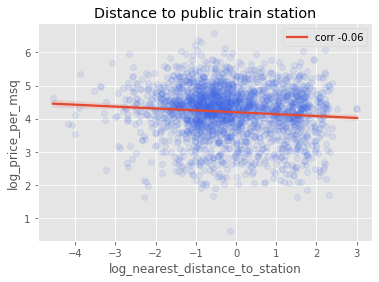

In [134]:
# @title

log_features = ['nearest_distance_to_station', 'nearest_bts_distance', 'nearest_mrt_distance', 'nearest_airportlink_distance', 'price_per_msq']

for col in log_features:
  condo_price['log_' + col] = condo_price[col].apply(lambda x: np.log(x))

sns.regplot(
    x = 'log_nearest_distance_to_station', 
    y = 'log_price_per_msq',
    data = condo_price,
    scatter_kws = {'alpha': 0.1, 'color': 'royalblue'}
).set(title = 'Distance to public train station')

plt.legend([f"corr {round(condo_price[log_features].corr().loc['price_per_msq', 'nearest_distance_to_station'], 2)}"])

However, If we deep dive into distance of each public train service. We will found that sale price and distance have **negative correlation**.   

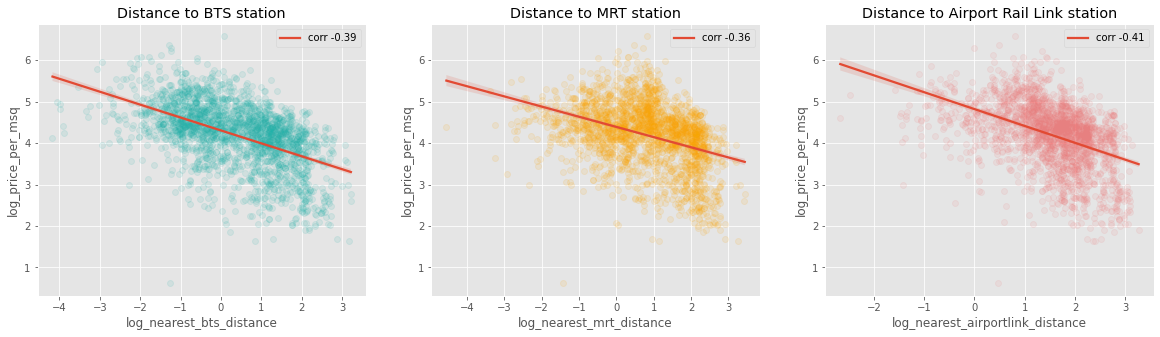

In [133]:
# @title

fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))

sns.regplot(
    x = 'log_nearest_bts_distance', 
    y = 'log_price_per_msq',
    data = condo_price,
    scatter_kws = {'alpha': 0.1, 'color': 'lightseagreen'},
    ax = axes[0]
).set(title = 'Distance to BTS station')

axes[0].legend([f"corr {round(condo_price[log_features].corr().loc['price_per_msq', 'nearest_bts_distance'], 2)}"])

sns.regplot(
    x = 'log_nearest_mrt_distance', 
    y = 'log_price_per_msq',
    data = condo_price,
    scatter_kws = {'alpha': 0.1, 'color': 'orange'},
    ax = axes[1]
).set(title = 'Distance to MRT station')

axes[1].legend([f"corr {round(condo_price[log_features].corr().loc['price_per_msq', 'nearest_mrt_distance'], 2)}"])

sns.regplot(
    x = 'log_nearest_airportlink_distance', 
    y = 'log_price_per_msq',
    data = condo_price,
    scatter_kws = {'alpha': 0.1, 'color': 'lightcoral'},
    ax = axes[2]
).set(title = 'Distance to Airport Rail Link station')

axes[2].legend([f"corr {round(condo_price[log_features].corr().loc['price_per_msq', 'nearest_airportlink_distance'], 2)}"])

Let's explore the coordinates of condo and public train station

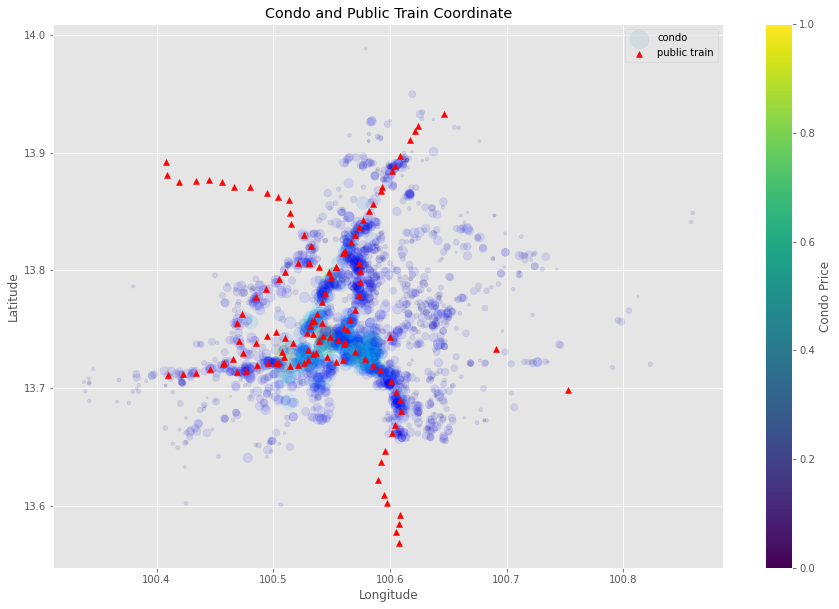

In [135]:
plt.figure(figsize = (15, 10))

plt.scatter(
    x = condo_price['lon'].values,
    y = condo_price['lat'].values,
    s = condo_price['price_per_msq'].values,
    alpha = 0.1,
    #color = 'lightseagreen', 
    c = condo_price['price_per_msq'].values,
    cmap = plt.get_cmap("jet")
)

plt.scatter(
    x = stations.loc[:, 'geoLng'],
    y = stations.loc[:, 'geoLat'],
    alpha = 1,
    color = 'red',
    marker = '^'
)

plt.legend(['condo', 'public train'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Condo and Public Train Coordinate')
plt.colorbar().set_label('Condo Price')

Condominiums located around public train service seems to have higer price

In [140]:
condo_price\
  .groupby('lineServiceName')['price_per_msq']\
  .describe()

,count,mean,std,min,25%,50%,75%,max
lineServiceName,,,,,,,,
AIRPORTLINK,286.0,87.546862,78.480736,6.428571,40.000000,73.197279,109.296240,719.047619
BTS,1276.0,89.321193,64.475716,1.842105,47.935049,76.137197,111.375181,545.454545
MRT,691.0,79.870468,56.221660,5.173913,42.312937,67.600000,101.290992,426.470588


Text(0.5, 1.0, 'AIRPORTLINK Area')

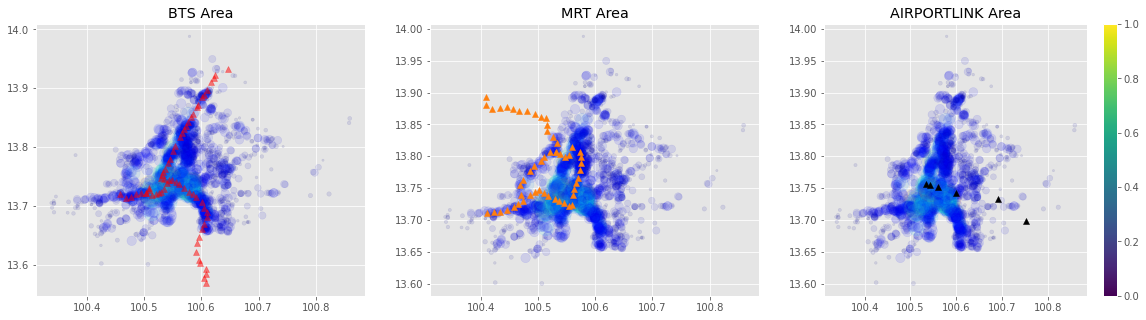

In [138]:
# @title

fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))

# BTS Area
axes[0].scatter(
    x = condo_price['lon'].values,
    y = condo_price['lat'].values,
    s = condo_price['price_per_msq'].values,
    alpha = 0.1,
    #color = 'royalblue', 
    c = condo_price['price_per_msq'].values ,
    cmap = plt.get_cmap("jet")
)


axes[0].scatter(
    x = stations[stations['lineServiceName'] == 'BTS'].loc[:, 'geoLng'],
    y = stations[stations['lineServiceName'] == 'BTS'].loc[:, 'geoLat'],
    alpha = 0.5,
    color = 'red',
    marker = '^'
)

axes[0].set_title('BTS Area')

# MRT Area
axes[1].scatter(
    x = condo_price['lon'].values,
    y = condo_price['lat'].values,
    s = condo_price['price_per_msq'].values,
    alpha = 0.1,
    #color = 'royalblue', 
    c = condo_price['price_per_msq'].values,
    cmap = plt.get_cmap("jet")
)


axes[1].scatter(
    x = stations[stations['lineServiceName'] == 'MRT'].loc[:, 'geoLng'],
    y = stations[stations['lineServiceName'] == 'MRT'].loc[:, 'geoLat'],
    alpha = 1,
    color = 'tab:orange',
    marker = '^'
)

axes[1].set_title('MRT Area')

# AIRPORTLINK Area
axes[2].scatter(
    x = condo_price['lon'].values,
    y = condo_price['lat'].values,
    s = condo_price['price_per_msq'].values,
    alpha = 0.1,
    #color = 'royalblue', 
    c = condo_price['price_per_msq'].values,
    cmap = plt.get_cmap("jet")
)

fig.colorbar(
  axes[2].scatter(
      x = stations[stations['lineServiceName'] == 'AIRPORTLINK'].loc[:, 'geoLng'],
      y = stations[stations['lineServiceName'] == 'AIRPORTLINK'].loc[:, 'geoLat'],
      alpha = 1,
      color = 'black',
      marker = '^'
  ),
  ax = axes[2]
)

axes[2].set_title('AIRPORTLINK Area')

#plt.suptitle('Condo and Public Train Coordinate')

### Does Living Area matter?

---


The location of the condo is one of the most important factors that people need to make a decision to buy condo.
<br> Let's inspect sale price by district

Text(0.5, 0, 'Median sale price (Thousand)')

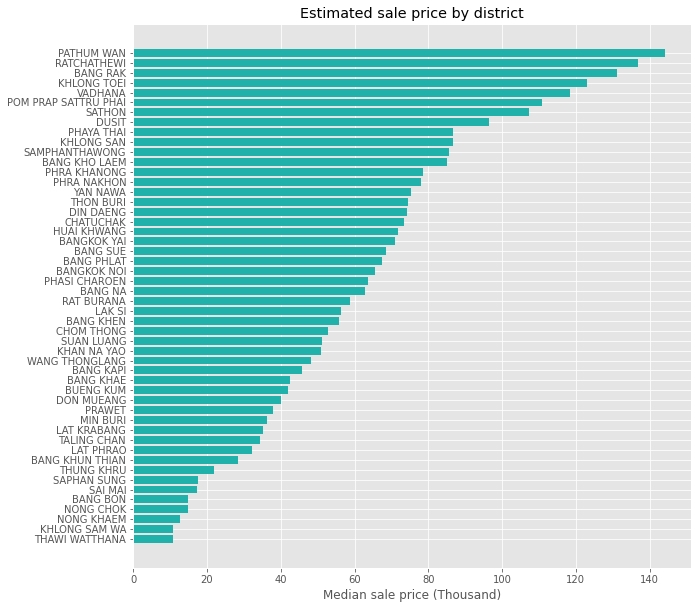

In [ ]:
price_by_district = condo_price.groupby(['district_title_en']).agg({
  'title_en': 'count',
  'price_per_msq': 'median'  
}).sort_values(by = 'price_per_msq')

plt.figure(figsize = (10, 10))
plt.rcParams.update({'font.size': 10})

plt.barh(
    price_by_district.index, 
    price_by_district.price_per_msq,
    color = 'lightseagreen'
  )
plt.title('Estimated sale price by district')
plt.xlabel('Median sale price (Thousand)')


As you can see from the above bar chart, different locations have different sale prices. Now, we try to make a group of district given sale price.

### Clustering and Location Segmentation

---


In this section, we are going to segment location by Agglomerative Clustering

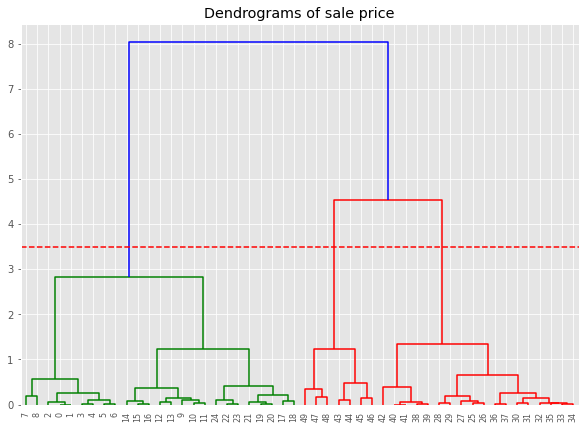

In [ ]:
import scipy.cluster.hierarchy as shc

price_by_district = condo_price.groupby(['district_title_en']).agg({
  'price_per_msq': 'median'  
}).sort_values(by = 'price_per_msq')

price_scaled = (price_by_district.values - price_by_district.values.mean()) / price_by_district.values.std()

plt.figure(figsize = (10, 7))  
plt.title("Dendrograms of sale price")  
dend = shc.dendrogram(shc.linkage(price_scaled, method = 'ward'))
plt.axhline(y = 3.5, color = 'r', linestyle = '--')

From the dendrogram, we will segment location into 3 groups

Text(0.5, 0, 'Median sale price (Thousand)')

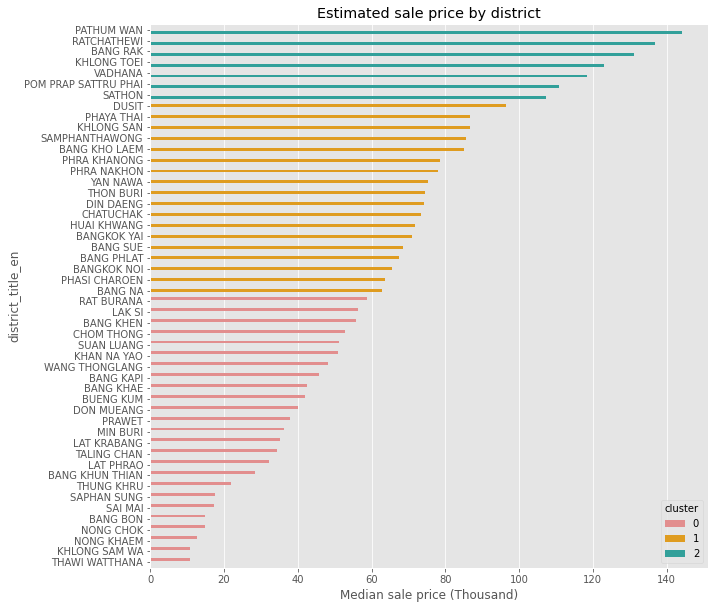

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')  
label = cluster.fit_predict(price_scaled)

price_by_district['cluster'] = label
price_by_district = price_by_district.sort_values(by = 'price_per_msq', ascending = False)

plt.figure(figsize = (10, 10))
plt.rcParams.update({'font.size': 10})

sns.barplot(
    x = price_by_district.price_per_msq, 
    y = price_by_district.index,
    hue = price_by_district.cluster,
    palette = {2: 'lightseagreen', 1: 'orange', 0: 'lightcoral'}
)

plt.title('Estimated sale price by district')
plt.xlabel('Median sale price (Thousand)')

Looks good!!! The prices are different from each location. The condominium has a higher price when located in the heart of Bangkok.

[Text(0.5, 1.0, 'Sale Price by District Segment')]

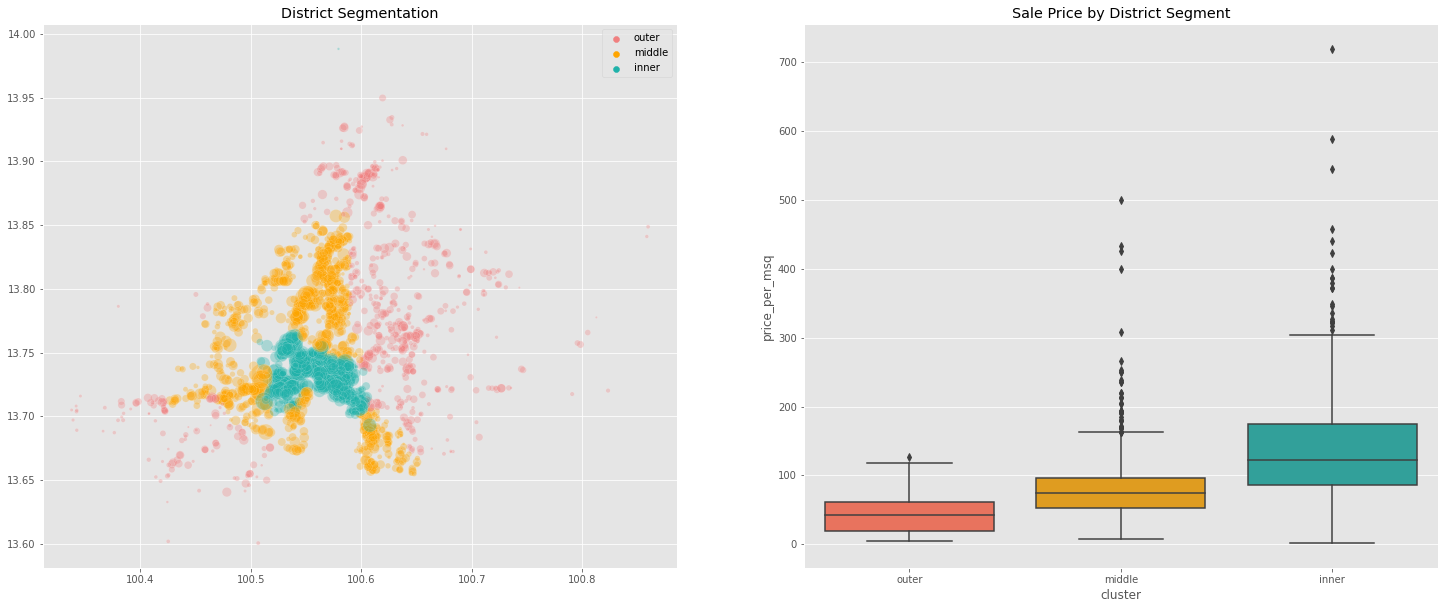

In [143]:
condo_location = condo_price.merge(
    price_by_district.reset_index()[['district_title_en', 'cluster']],
    on = 'district_title_en'
)

condo_location['cluster'] = condo_location['cluster'].replace({2: 'inner', 1: 'middle', 0: 'outer'})

fig, axes = plt.subplots(ncols = 2, figsize = (25, 10))

#plt.figure(figsize = (10, 10))

sns.scatterplot(
    x = condo_location['lon'].values,
    y = condo_location['lat'].values,
    s = condo_location['price_per_msq'].values,
    alpha = 0.3,
    #color = 'royalblue', 
    hue = condo_location['cluster'].values,
    palette = {'inner': 'lightseagreen', 'middle': 'orange', 'outer': 'lightcoral'},
    #cmap = plt.get_cmap("jet"),
    ax = axes[0]
).set(title = 'District Segmentation')

sns.boxplot(
    x = 'cluster',
    y = 'price_per_msq',
    data = condo_location,
    palette = {'inner': 'lightseagreen', 'middle': 'orange', 'outer': 'tomato'},
    ax = axes[1]
).set(title = 'Sale Price by District Segment')

## Conclusion

---



In this notebook, we found what might effects condominium sale prices. 
<br> Based on above analysis, we can conclude that:
- **Distance** to BTS, MRT and Airport Rail Link seem to be linearly correlated with sale price. What does that mean? It means that the price will increse if the condo closes to BTS, MRT or Airport Rail Link station. 
- **Location** and living area also effect the condo price. The sale price of condo located in the heart of Bangkok (Inner Area) seems to be higher than those located in the Outer Area.     
- Besides of disatnces and location, the **facilities** also effect the sale price.

Hope you enjoy exploring the data 😃

In [144]:
!jupyter nbconvert --to html /content/BKK_Condo_Pricing_Analysis.ipynb

[NbConvertApp] Converting notebook /content/BKK_Condo_Pricing_Analysis.ipynb to html
[NbConvertApp] Writing 1580937 bytes to /content/BKK_Condo_Pricing_Analysis.html
